In [1]:
import os
import sys

sys.path.append("../")

envkey = "OMP_NUM_THREADS"
# Set this environment variable to the number of available cores in your machine,
# to get a fast execution of the Einstein Boltzmann Solver
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(12)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  None
The value of OMP_NUM_THREADS is:  12


In [2]:
import astropy.units as u

nu = 115 * u.GHz
nuObs = 30 * u.GHz

zc = (nu / nuObs - 1).to(1).value
dz = 0.1

Delta_nu = nu/(1+zc-dz) - nu/(1+zc+dz)

In [3]:
import astropy.units as u
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numba
import numpy as np
import seaborn
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from copy import copy

In [4]:
seaborn.set_theme(rc={'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black',})
Cp = seaborn.color_palette("Paired")
Cp

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [5]:
seaborn.set_theme(rc={'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black',})
Cs = seaborn.color_palette("Set2")
Cs

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [6]:
from SSLimPy.cosmology import astro as sastro
from SSLimPy.cosmology import cosmology, halo_model
from SSLimPy.interface import sslimpy
from SSLimPy.interface import survey_specs as sss
from SSLimPy.LIMsurvey import covariance as scov
from SSLimPy.LIMsurvey import higher_order
from SSLimPy.LIMsurvey import power_spectrum as sps
from SSLimPy.LIMsurvey import ingredients_T0
from SSLimPy.utils import fft_log
from SSLimPy.utils.utils import *

[]

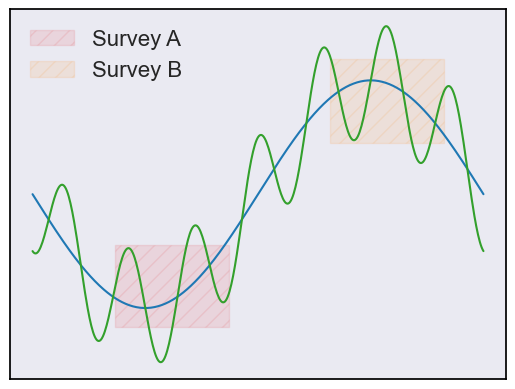

In [6]:
fig, ax = plt.subplots()

x= np.linspace(-np.pi, np.pi, num=500)

longmode = 0.2 * np.sin(x)
smallmode = 0.1 * np.cos(7*x)
crit =  0. * np.ones_like(x)

plt.plot(x, longmode, color=Cp[1])
plt.plot(x, longmode + smallmode, color=Cp[3])
# plt.plot(x, crit, "k--")
# plt.fill_between(x, longmode + smallmode, crit, where= longmode + smallmode > crit, alpha=0.3, color=Cp[3])

ismallx = np.where(np.logical_and(x>-2, x<-0.4))
smallx = x[ismallx]
meansmallx = np.mean((longmode+smallmode)[ismallx])
vsmallx = np.sqrt(np.var((longmode+smallmode)[ismallx]))

ilarge = np.where(np.logical_and(x<2.6, x>1))
largex = x[ilarge]
meanlargex = np.mean((longmode+smallmode)[ilarge])
vlargex = np.sqrt(np.var((longmode+smallmode)[ilarge]))


plt.fill_between(smallx, meansmallx - vsmallx, meansmallx + vsmallx, alpha=0.1, color=Cp[5], hatch="//", label="Survey A")
plt.fill_between(largex, meanlargex - vlargex, meanlargex + vlargex, alpha=0.1, color=Cp[7], hatch="//", label="Survey B")
plt.legend(frameon=False, fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

In [86]:
np.array([*Cp[3]]) * 276

array([ 55.2       , 173.17647059,  47.62352941])

In [8]:
kminebs=1e-5
kmaxebs=50

settings = {"code":"class",
            "do_RSD" : False,
            "nonlinearRSD" : False,
            "FoG_damp" : "ISTF_like",
            "halo_model_PS" : True,
            "Smooth_window" : False,
            "nk":200,
            "kmax": kmaxebs*u.Mpc**-1,
            "kmin": kminebs*u.Mpc**-1,
            "Smooth_resolution": False,
            "LogN_modes": 13,            
            }

sslimpy.sslimpy(settings_dict=settings)

  █████   █████  █       █            █████   █    █ 
 █     █ █     █ █            █   █   █    █  █   █  
 █       █       █     ███   █ █ █ █  █    █   █ █   
  █████   █████  █       █   █  █  █  █████     █    
       █       █ █       █   █     █  █        █     
 █     █ █     █ █       █   █     █  █       █      
  █████   █████  █████ █████ █     █  █      █       

#---------------------------------------------------#


In [9]:
s_cosmo = cosmology.CosmoFunctions(cosmopars=cosmo_dict)
s_halo = halo_model.HaloModel(s_cosmo, halo_dict)

survey_dict = copy(survey_dict_base)
survey_dict["Omega_field"] = 14*u.deg**2

survey_specs = sss.SurveySpecifications(survey_dict, s_cosmo)
astro = sastro.AstroFunctions(s_halo, survey_specs) #, astropars=astro_dict)

kgrid = s_halo.k
Pgrid = s_halo.cosmology.matpow(kgrid, 0, tracer="clustering")

In [10]:
kmin = 5e-3*u.Mpc**-1
kmax = 5*u.Mpc**-1
pobs_settings = {"nk":100,
            "kmin": kmin,
            "kmax": kmax,
            "nmu":20
            }

In [11]:
pobs = sps.PowerSpectra(astro, dict(), pobs_settings)
cov = scov.nonGuassianCov(pobs)

In [12]:
T4h = cov.integrate_4h()
T3h = cov.integrate_3h()
T2h = cov.integrate_2h()
T1h = cov.integrate_1h()
Total = T4h+T3h+T2h+T1h

/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:72: RuntimeWarning: divide by zero encountered in divide
  * np.log(((k1 + k2) / np.abs(k1 - k2)))
/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:72: RuntimeWarning: invalid value encountered in divide
  * np.log(((k1 + k2) / np.abs(k1 - k2)))
/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:307: RuntimeWarning: invalid value encountered in power
  * np.power(np.abs(k1 - k2), an)
/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:618: RuntimeWarning: invalid value encountered in power
  * np.power(np.abs(k1 - k2), an)
/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/

In [13]:
k = pobs.k
mu = pobs.mu
z = pobs.z
Pk = pobs.cosmology.matpow(k, z, nonlinear=False, tracer="clustering")

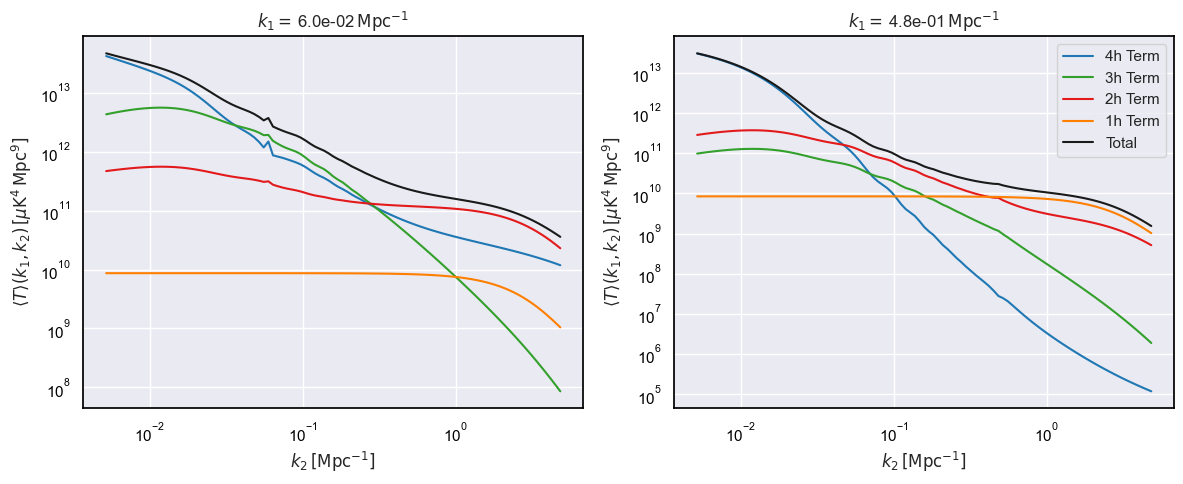

In [14]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
indicies = [35, 65]

for index, axi in zip(indicies, axs):
    axi.loglog(k, T4h[:, index, 0], c=Cp[1], label="4h Term")
    axi.loglog(k, T3h[:, index, 0], c=Cp[3], label="3h Term")
    axi.loglog(k, T2h[:, index, 0], c=Cp[5], label="2h Term")
    axi.loglog(k, T1h[:, index, 0], c=Cp[7], label="1h Term")
    axi.loglog(k, Total[:, index, 0], c="k", label="Total")
    axi.set_ylabel(r"$\left\langle T\right\rangle(k_1, k_2)\,[\mu\mathrm{K}^4\,\mathrm{Mpc}^9]$")
    axi.set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
    axi.set_title(r"$k_1=\,$"+"{:.1e}".format(k[index].value)+r"$\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.tight_layout()

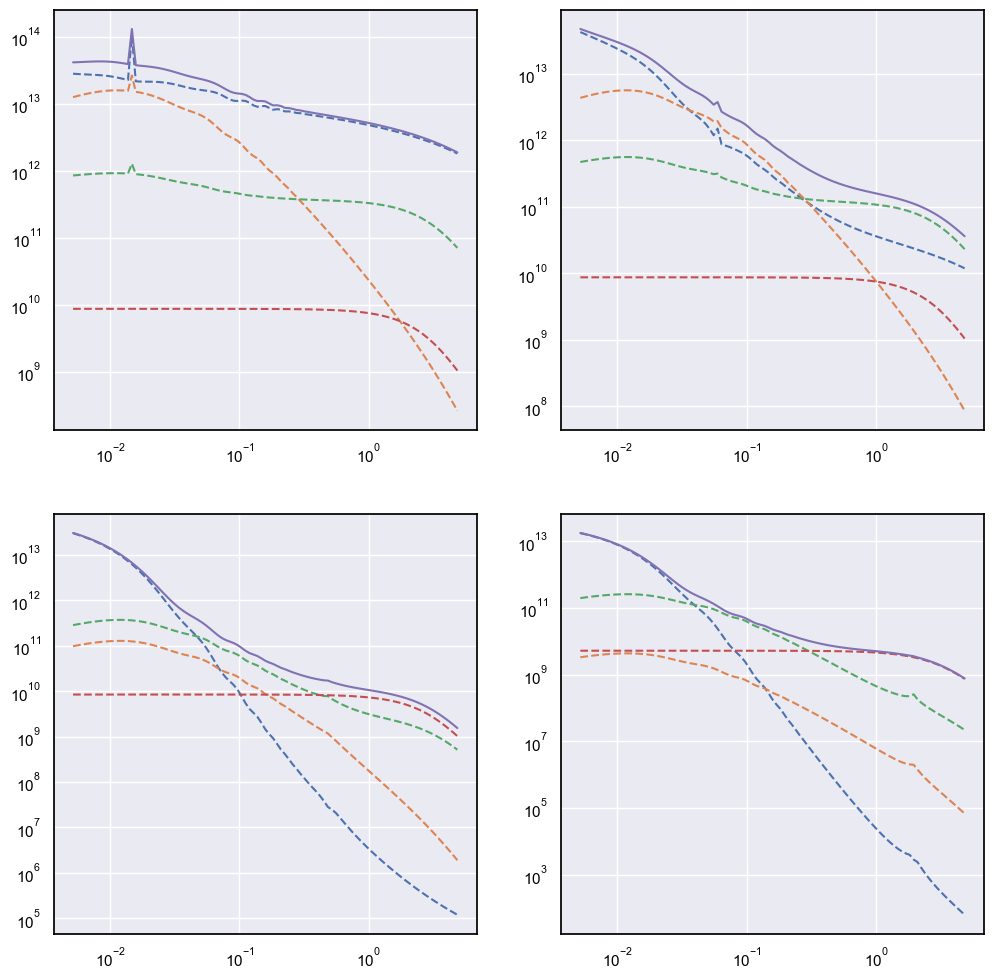

In [15]:
indicies = [15, 35, 65, 85]

fig, axs = plt.subplots(2, 2, figsize=(12,12))
for index, axi in zip(indicies, axs.flatten()):
    axi.loglog(k, T4h[:, index, 0], "--")
    axi.loglog(k, T3h[:, index, 0], "--")
    axi.loglog(k, T2h[:, index, 0], "--")
    axi.loglog(k, T1h[:, index, 0], "--")
    axi.loglog(k, Total[:, index, 0])
    # axi.set_xlim(6e-3, 1)

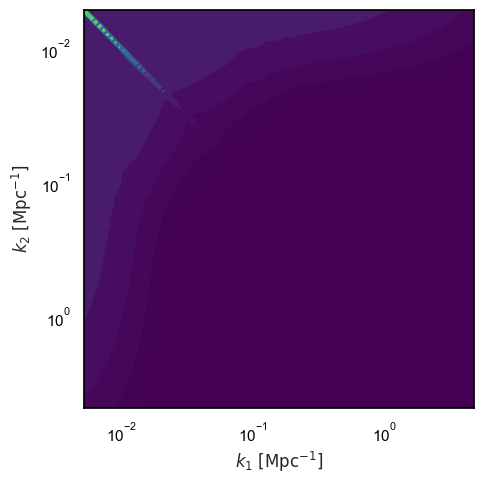

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

Z = Total[:,:, 0].value.copy()
Z[Z <= 0] = np.nan  # Avoid log of 0 or negative

log_min = np.nanmin(np.log10(Z))
log_max = np.nanmax(np.log10(Z))
log_levels = np.logspace(log_min, log_max, num=20)  # 20 contour levels

cf = plt.contourf(k, k, Z, levels=log_levels, cmap='viridis')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$k_1\ [\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$k_2\ [\mathrm{Mpc}^{-1}]$')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


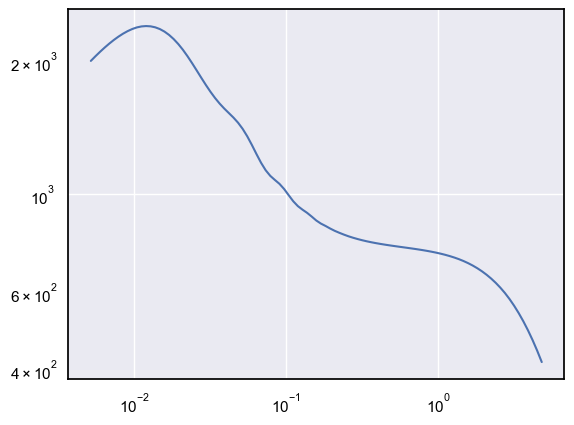

In [17]:
plt.loglog(k, pobs.Pk_0bs)

In [18]:
from SSLimPy.interface import updater
from SSLimPy.interface import survey_specs as sSurvey

In [19]:
@numba.njit("(float64[::1], float64, float64, float64)")
def get_phi_vec(dPhi, k, q, mu):
    kq = np.empty_like(dPhi)
    muq = np.empty_like(dPhi)
    phq = np.empty_like(dPhi)

    for i, phi in enumerate(dPhi):
        kq[i], muq[i], phq[i]  = addVectors(q, mu, phi, k, -1, np.pi)
    return kq, muq, phq

In [20]:
@numba.njit("(float64, float64, float64, float64)")
def get_window(k, mu, Lperp, Lparr):
    qparr = k * mu
    qperp = k * np.sqrt(1 - mu**2)
    
    xparr = (qparr * Lparr) / 2
    Wparr = Lparr * np.sinc(xparr / np.pi)

    xperp = qperp * Lperp
    Wperp = 2 * np.pi * Lperp * smooth_W(np.array([xperp]))[0] / qperp
    return Wparr * Wperp

In [21]:
@numba.njit("(float64, float64, float64, float64, float64[::1], float64[::1], float64, float64)")
def phi_integrand(dPhi, k, q, mu, kgrid, Pk, Lperp, Lparr):
    kmq, _, _ = addVectors(k, 1, 0.0, q, -mu, dPhi+np.pi)

    Wq = get_window(q, mu, Lperp, Lparr)
    Pkmq = np.exp(
        linear_interpolate(
            np.log(kgrid),
            np.log(Pk),
            np.log(np.array([kmq])),
            )[0]
    )
    return Wq**2 * Pkmq

In [22]:
from scipy.special import roots_legendre

In [23]:
@numba.njit("float64[::1], float64[::1], float64, float64, float64[::1], float64[::1]", parallel=True)
def getPk_conv(k, Pk, Lerp, Lparr, mu, wi):
    lk = len(k)
    nmu = len(mu)

    Pk_conv_mu = np.empty((lk, nmu))
    for ik in numba.prange(lk):
        ki = k[ik]
        for imu in range(nmu):
            mui = mu[imu]
            q_int = np.empty_like(k)
            for iq in range(lk):
                qi = k[iq]
                q_int[iq] = qi**2 * adaptive_mesh_integral(
                    -np.pi, np.pi,
                    phi_integrand,
                    args=(ki, qi, mui, k, Pk, Lerp, Lparr))
            dlogq = np.diff(np.log(k))
            trapezoid = (q_int[1:] + q_int[1:]) / 2
            Pk_conv_mu[ik, imu] = np.sum(dlogq *trapezoid)
    Pk_conv = np.sum(wi * Pk_conv_mu, axis=-1) / (2 * np.pi)**3
    return Pk_conv

In [24]:
def get_lengths(survey_specs: sss.SurveySpecifications):
    z_min, z, z_max = survey_specs.get_redshifts()
    Sfield = survey_specs.Sfield(z, survey_specs.obsparams["Omega_field"])
    Lperp = np.sqrt(Sfield / np.pi)
    Lparr = survey_specs.Lfield(z_min, z_max)
    return Lperp, Lparr, z

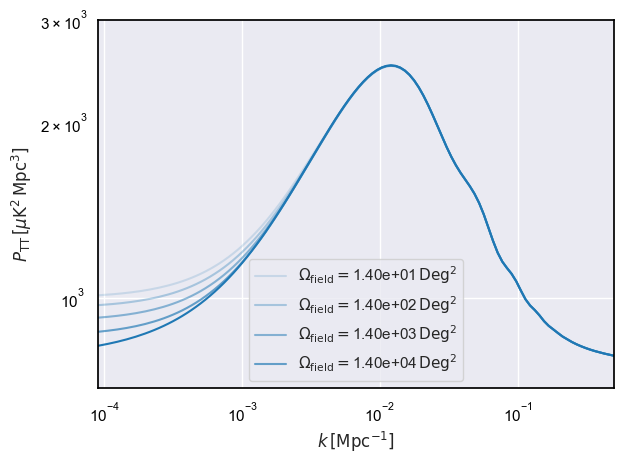

In [25]:
mu, wi = roots_legendre(12)

Omega_field = np.array([14, 140, 1400, 14000]) * u.deg**2
sigmasq = []
Pkconv = []
astroi = astro

alpha = np.linspace(0,1, 7)[1:-1]

cosmo_dict = astro.cosmology.cosmopars
halo_dict = astro.halomodel.haloparams

for i, Omi in enumerate(Omega_field):
    survey_specs = {"Omega_field": Omi}
    astroi = updater.update_astro(astroi, cosmo_dict, halo_dict, halo_dict, survey_specs)
    survey = astroi.survey_specs

    pobsi = sps.PowerSpectra(astroi, dict())
    Pgrid_sk = pobsi.Pk_0bs[:, 0]
    Lperp, Lparr, zgrid = get_lengths(survey)

    Pk_conv = getPk_conv(kgrid.value, Pgrid_sk.value, Lperp.value, Lparr.value, mu, wi)

    plt.loglog(kgrid, Pk_conv  * Pgrid_sk[-1]/Pk_conv[-1], c=Cp[1], alpha=alpha[i], label=r"$\Omega_\mathrm{field}=$"+"{:.2e}".format(Omi.value)+r"$\,\mathrm{Deg}^2$")
plt.loglog(kgrid, Pgrid_sk, c=Cp[1])

plt.legend()
plt.ylabel(r"$P_\mathrm{TT}\,[\mu\mathrm{K}^2\,\mathrm{Mpc}^3]$")
plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.xlim(0.9e-4, 0.5e0)
plt.ylim(0.7e3, 3e3)

plt.tight_layout()

plt.savefig("output/Smoother_Pk_vs_OmegaField")

In [26]:
Omax = 14000 * u.deg**2
Omega_field = np.geomspace(14 * u.deg**2, Omax, num=50)

sigmasq = []
Nmodes = []
astroi = astro

cosmo_dict = astro.cosmology.cosmopars
halo_dict = astro.halomodel.haloparams

for Omi in Omega_field:
    survey_specs = {"Omega_field": Omi}
    astroi = updater.update_astro(astroi, cosmo_dict, halo_dict, halo_dict, survey_specs)
    survey = astroi.survey_specs

    pobsi = sps.PowerSpectra(astroi, dict())

    ssccov = scov.SuperSampleCovariance(pobsi)
    GOcov = scov.Covariance(pobsi)

    sigma = ssccov.sigma_survey()
    pref = (sigma / ssccov.survey_specs.Vfield()).to(1).value
    Nmodes.append(GOcov.Nmodes())
    sigmasq.append(pref)

In [27]:
Nmodes = np.array(Nmodes)
Nmodes.shape

(50, 199, 1)

Text(0, 0.5, '$\\sigma^2 / V_\\mathrm{field}$')

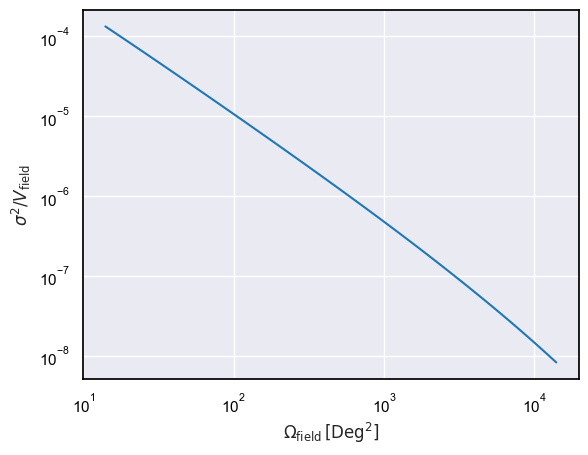

In [28]:
plt.loglog(Omega_field, sigmasq, c=Cp[1])
plt.xlabel(r"$\Omega_\mathrm{field}\,[\mathrm{Deg}^2]$")
plt.ylabel(r"$\sigma^2 / V_\mathrm{field}$")

In [29]:
z = pobs.z
I11 = astro.Thalo(z, k, p=1, scale=(1,), beta=1)
I02 = astro.Thalo(z, k, p=1, scale=(2,), beta=0)
Pk_HM = I11**2 * Pk + I02

In [30]:
SSC_cov = scov.SuperSampleCovariance(pobs)
SSC = SSC_cov.compute_SSC()

(0.01, 5)

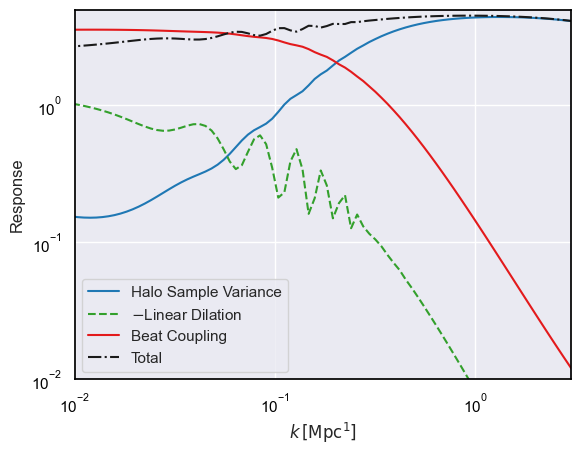

In [31]:
z = np.atleast_1d(z)

hsv = np.squeeze(SSC_cov.halo_sample_variance(k, z))
ld = np.squeeze(SSC_cov.linear_dilation(k, z)) * Pk
bc = np.squeeze(SSC_cov.beat_coupling(k, z)) * Pk
rsp = hsv + ld + bc

plt.loglog(k, hsv / Pk_HM, c=Cp[1], label="Halo Sample Variance")
plt.loglog(k, -ld / Pk_HM, "--", c=Cp[3], label="$-$Linear Dilation")
plt.loglog(k, bc / Pk_HM, c=Cp[5], label="Beat Coupling")
plt.loglog(k, rsp / Pk_HM, "k-.", label="Total")

plt.xlabel(r"$k\,[\mathrm{Mpc}^1]$")
plt.ylabel(r"Response")
plt.legend(loc="lower left")
plt.xlim(1e-2, 3)
plt.ylim(1e-2, 5)

0.016240630673635282 1 / Mpc
0.00753823299855747 1 / Mpc
0.0034989378111275737 1 / Mpc
0.0016240630673635284 1 / Mpc


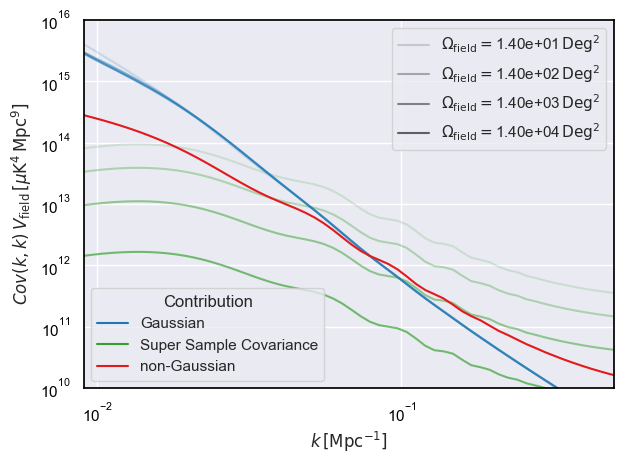

In [32]:

Omega_field = np.array([14, 140, 1400, 14000]) * u.deg**2

fig, axs = plt.subplots(1,1)

# ---------- Legend for line styles ----------
ngaline = mlines.Line2D([], [], color=Cp[1], label='Gaussian')
sscline = mlines.Line2D([], [], color=Cp[3], label='Super Sample Covariance')
scatter = mlines.Line2D([], [], color=Cp[5], label='non-Gaussian')
legend1 = axs.legend(handles=[ngaline, sscline, scatter], loc='lower left', title="Contribution")
axs.add_artist(legend1)  # add manually so it's not overwritten


for i, Omi in enumerate(Omega_field):
    survey_specs = {"Omega_field": Omi}
    astroi = updater.update_astro(astroi, cosmo_dict, halo_dict, halo_dict, survey_specs)
    survey = astroi.survey_specs

    pobsi = sps.PowerSpectra(astroi, settings=pobs_settings)
    ssccov = scov.SuperSampleCovariance(pobsi)
    GOcov = scov.Covariance(pobsi)

    V = survey.Vfield()

    Pgrid_sk = pobsi.Pk_0bs[:, 0]
    kgrid = pobsi.k

    Lperp, Lparr, zgrid = get_lengths(survey)
    print(2 * np.pi/(Lperp**2 * Lparr)**(1/3))

    Pk_conv = getPk_conv(kgrid.value, Pgrid_sk.value, Lperp.value, Lparr.value, mu, wi)
    Pk_conv = Pk_conv * Pgrid_sk[-1] / Pk_conv[-1]
    PI = survey.detector_noise(zgrid)

    GOn = np.squeeze((Pk_conv + PI) ** 2 / GOcov.Nmodes()[:, 0]) * V
    SSCn = np.diag(ssccov.compute_SSC()[:, :, 0]) * V
    T0n = np.diag(Total[:, :, 0])

    label = r"$\Omega_\mathrm{field}=$"+"{:.2e}".format(Omi.value)+r"$\,\mathrm{Deg}^2$"
    #plt.loglog(pobsi.k, SSCn + T0n + GOn, c=Cp[1], alpha=alpha[i], label=label)
    plt.loglog(pobsi.k, GOn, c=Cp[1], alpha=alpha[i])
    plt.loglog(pobsi.k, SSCn, c=Cp[3], alpha=alpha[i])
    plt.loglog([],[], alpha=alpha[i], label=label, c="k" )

plt.loglog(pobsi.k, T0n, c=Cp[5])

plt.legend()
plt.ylabel(r"$Cov(k,k)\,V_\mathrm{field}\,[\mu\mathrm{K}^4\,\mathrm{Mpc}^9]$")
plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")

plt.xlim(0.9e-2, 0.5e0)
plt.ylim(1e10, 1e16)

plt.tight_layout()
plt.savefig("output/Diag_Covariance_vs_OmegaField")

In [33]:
def get_covariances(Omfield):
    survey_specs = {"Omega_field": Omfield}
    astroi = updater.update_astro(astro, cosmo_dict, halo_dict, halo_dict, survey_specs)
    survey = astroi.survey_specs

    pobsi = sps.PowerSpectra(astroi, dict())
    ssccov = scov.SuperSampleCovariance(pobsi)
    GOcov = scov.Covariance(pobsi)

    pobsi = sps.PowerSpectra(astroi, dict(), settings=pobs_settings)
    ssccov = scov.SuperSampleCovariance(pobsi)
    GOcov = scov.Covariance(pobsi)

    V = survey.Vfield()
    kgrid = pobsi.k
    Pgrid_sk = pobsi.Pk_0bs[:, 0]
    Lperp, Lparr, zgrid = get_lengths(survey)
    Pk_conv = getPk_conv(kgrid.value, Pgrid_sk.value, Lperp.value, Lparr.value, mu, wi)
    Pk_conv = Pk_conv * Pgrid_sk[-1] / Pk_conv[-1]
    PI = survey.detector_noise(zgrid)

    NG_cov = np.squeeze(Total / V)
    GO = np.squeeze((Pk_conv + PI) ** 2 / GOcov.Nmodes()[:, 0])
    SSC = np.squeeze(ssccov.compute_SSC())
    return GO, NG_cov, SSC

In [34]:
def plot_diag(Omfield, title):
    GO, NG_cov, SSC = get_covariances(Omfield)

    NG_diag = np.diag(NG_cov)
    SSC_diag = np.diag(SSC)

    plt.title(r"Covaiance with $\Omega_\mathrm{field}=$"+str(Omfield.to(u.deg**2).value)+r"$\,\mathrm{Deg}^2$")
    plt.loglog(k, GO, ls="--", c=Cs[0], label = "Gaussian")
    plt.loglog(k, NG_diag, ls="--", c=Cs[1], label = "non-Gaussian")
    plt.loglog(k, SSC_diag, ls="--", c=Cs[2], label = "Super Sample")
    plt.loglog(k, GO + NG_diag + SSC_diag, c="black", label="Total")
    plt.ylabel(r"$Cov(k,k)\,[\mu\mathrm{K}^4\,\mathrm{Mpc}^6]$")
    plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
    plt.legend()
    plt.tight_layout()
    plt.savefig(title)

In [35]:
survey.get_redshifts()

(2.3823529411764706, 2.8333333333333335, 3.4230769230769234)

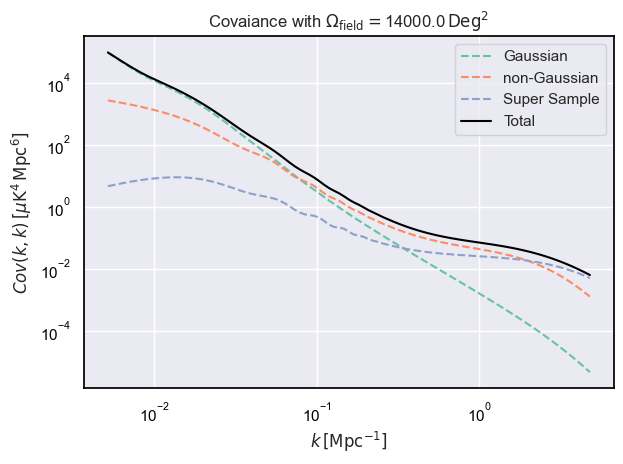

In [36]:
plot_diag(14000*u.deg**2, "output/total_covariance_14000deg2")

In [37]:
def plot_correlation(Omfield, title):
    G, NG, SSC = get_covariances(Omfield)
    G_delta = np.diag(G)

    Cov = G_delta + NG + SSC
    dCov = np.diag(Cov)
    Corr =  Cov / np.sqrt(np.outer(dCov, dCov))

    fig, ax = plt.subplots()
    cmap_choice = 'viridis' 

    plt.title(r"Correlation with $\Omega_\mathrm{field}=$"+str(Omfield.to(u.deg**2).value)+r"$\,\mathrm{Deg}^2$")

    cax = ax.imshow(
        Corr,
        cmap=cmap_choice,
        vmin=0, vmax=1)

    cbar = fig.colorbar(cax)
    cbar.set_label('Correlation')
    ax.set_xlabel(r'$k_2\,[\mathrm{Mpc}^{-1}]$')
    ax.set_ylabel(r'$k_1\,[\mathrm{Mpc}^{-1}]$')

    q_vals = k.value

    log_ticks = np.arange(np.ceil(np.log10(q_vals[0])), np.floor(np.log10(q_vals[-1])) + 1)
    tick_values = 10 ** log_ticks
    tick_indices = [np.argmin(np.abs(q_vals - val)) for val in tick_values]
    tick_labels = [f"$10^{{{int(t)}}}$" for t in log_ticks]

    # Apply to plot
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_indices)
    ax.set_yticklabels(tick_labels)

    fig.tight_layout()
    plt.savefig(title)

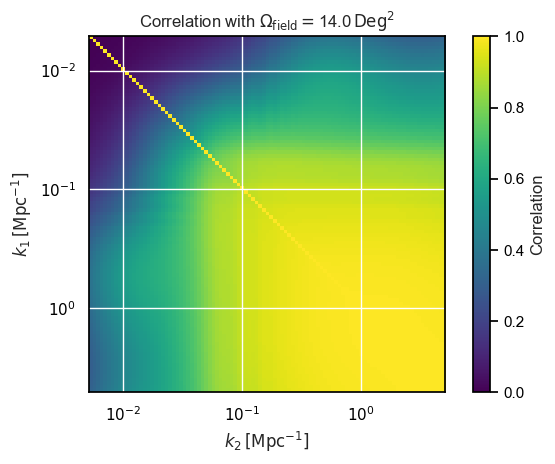

In [38]:
plot_correlation(14 * u.deg**2, "output/Corr_14Deg2")

In [95]:
G, NG, SSC = get_covariances(14000 * u.deg**2)
Total_cov = NG + SSC + np.diag(G)

<Quantity 0.01040917 1 / Mpc>

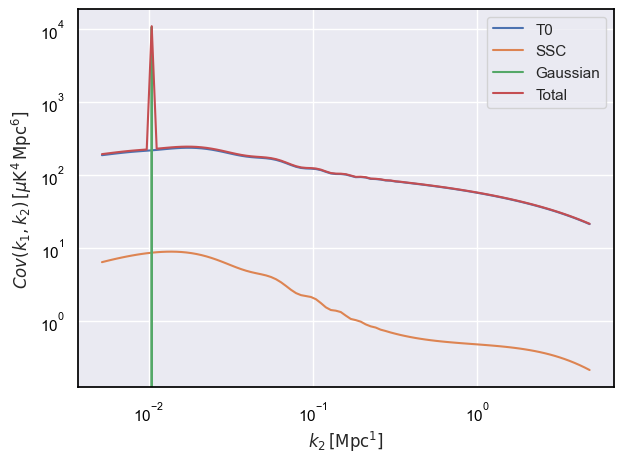

In [59]:
plt.loglog(k, NG[10, :], label = "T0")
plt.loglog(k, SSC[10, :], label = "SSC")
plt.loglog(k, np.diag(G)[10, :], label="Gaussian")
plt.loglog(k, Total_cov[10, :], label="Total")
plt.legend()
plt.xlabel(r"$k_2\,[\mathrm{Mpc}^1]$")
plt.ylabel(r"$Cov(k_1,k_2)\,[\mu \mathrm{K}^4\,\mathrm{Mpc}^6]$")
plt.tight_layout()

In [ ]:
plt.loglog(k, )

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))
axs[0].loglog(k, T4h[45, :, 0]/V,c=Cs[0], label="4-Halo")
axs[0].loglog(k, T3h[45, :, 0]/V,c=Cs[1], label="3-Halo")
axs[0].loglog(k, T2h[45, :, 0]/V,c=Cs[2], label="2-Halo")
axs[0].loglog(k, T1h[45, :, 0]/V,c=Cs[3], label="1-Halo")
axs[0].loglog(k, NG_cov[45, :, 0],"k--",label="total")
axs[0].scatter(k[45], G_Cov[45, 0, 0, 0], label="Gaussian")
axs[0].set_title(r"$k_1={:.2f}\, [\mathrm{{Mpc}}^{{-1}}]$".format(k[45].value))

axs[1].loglog(k, T4h[75, :, 0]/V,c=Cs[0], label="4-Halo")
axs[1].loglog(k, T3h[75, :, 0]/V,c=Cs[1], label="3-Halo")
axs[1].loglog(k, T2h[75, :, 0]/V,c=Cs[2], label="2-Halo")
axs[1].loglog(k, T1h[75, :, 0]/V,c=Cs[3], label="1-Halo")
axs[1].loglog(k, NG_cov[75, :, 0],"k--",label="total")
axs[1].scatter(k[75], G_Cov[75, 0, 0, 0], label="Gaussian")
axs[1].set_title(r"$k_1={:.2f}\, [\mathrm{{Mpc}}^{{-1}}]$".format(k[75].value))

plt.legend()

In [ ]:
NG_diag = np.diag(DCov_Tk)
G_diag = np.diag(DCov_Pk)
SSC_diag = np.diag(SSC[:,:,0])

plt.xlabel(r"$k\,[\mathrm{Mpc}^1]$")
plt.ylabel(r"$Cov(k,k)\,[\mu \mathrm{K}^4\,\mathrm{Mpc}^6]$")

plt.loglog(k, G_diag, c=Cs[0], label="Gaussian Cov.")
plt.loglog(k, NG_diag, c=Cs[1], label="Non-Gaussian Cov.")
plt.loglog(k, SSC_diag, c=Cs[2], label="SSC")

plt.legend()

In [ ]:
plt.loglog(k, DCov_Pk[:, 35])
plt.loglog(k, DCov_Tk[:, 35])
plt.loglog(k, SSC[:,35, 0])

In [ ]:


indicies = [10, 45, 75]
colors = iter(Cp)

fig, axs = plt.subplots(1,1)

for index in indicies:
    axs.loglog(k, SSC[:,index, 0], c=next(colors), ls="-")
    c = next(colors)
    axs.loglog(k, DCov_Tk[:,index], c=c, ls="--")
    axs.loglog(k, DCov_Pk[:,index], c=c, ls="", marker =".")


# ---------- Legend for line styles ----------
ngaline = mlines.Line2D([], [], color='gray', linestyle='--', label='non-Gaussian')
sscline = mlines.Line2D([], [], color='gray', linestyle='-', label='Super Sample Covariance')
scatter = plt.scatter([], [], color='gray', marker=".", label='Gaussian')
legend1 = axs.legend(handles=[ngaline, sscline, scatter], loc='upper right', title="Contribution")
axs.add_artist(legend1)  # add manually so it's not overwritten

# ---------- Legend for colors (k1 values) ----------
color_labels = []
for i in indicies:
    k1_val = k.value[i]
    exponent = int(np.floor(np.log10(k1_val)))
    mantissa = k1_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}$"
    color_labels.append(label)

# Create legend handles with correct colors (every second color if using next(colors) twice)
color_handles = [
    mlines.Line2D([], [], color=Cp[i*2 +1], linestyle='-', label=label)
    for i, label in enumerate(color_labels)
]

plt.xlabel(r"$k_2\,[\mathrm{Mpc}^1]$")
plt.ylabel(r"$Cov(k_1,k_2)\,[\mu \mathrm{K}^4\,\mathrm{Mpc}^6]$")

axs.legend(handles=color_handles, loc='lower left', title=r"$k_1$ values")

In [ ]:
def plot_corr(A):
    fig, ax = plt.subplots()

    Corr = getCorr(A)

    cmap_choice = 'viridis' 
    C_log_safe = np.clip(Corr, 1e-6, None)

    cax = ax.imshow(
        C_log_safe,
        cmap=cmap_choice,
        norm=colors.LogNorm(vmin=C_log_safe.min(), vmax=C_log_safe.max())
    )

    cbar = fig.colorbar(cax)
    cbar.set_label('Corrlation')
    ax.set_xlabel(r'$k_2\,[\mathrm{Mpc}^{-1}]$')
    ax.set_ylabel(r'$k_1\,[\mathrm{Mpc}^{-1}]$')

    # Suppose q_vals represents the underlying log-spaced physical values (e.g., logspace)
    q_vals = k.value

    log_ticks = np.arange(np.ceil(np.log10(q_vals[0])), np.floor(np.log10(q_vals[-1])) + 1)
    tick_values = 10 ** log_ticks

    # Find the indices in q_vals closest to these tick_values
    tick_indices = [np.argmin(np.abs(q_vals - val)) for val in tick_values]
    tick_labels = [f"$10^{{{int(t)}}}$" for t in log_ticks]

    # Apply to plot
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_indices)
    ax.set_yticklabels(tick_labels)

    plt.show()

In [ ]:
plot_corr(DCov_Pk + SSC[:,:,0])

In [ ]:
plt.loglog(kgrid, Pgrid)
plt.loglog(k, Pk,"--")

In [ ]:
Lmb1 = astro.bavg("b1", z, 1)
print("Luminosity weight bias:", Lmb1)

R = s_halo.R
n_eff = s_halo.n_eff_of_z(R,0,"clustering")
nu = -1/(np.mean(n_eff))

plt.semilogx(R, n_eff, c=Cs[0])
plt.xlabel("Scale [Mpc]")
plt.ylabel("Powerlaw slope")
print("log-avraged power-law slope:", nu)


In [ ]:
def extrap_pk(k, kgrid, Pkgrid):
    logk = np.log(k)
    logkgrid = np.log(kgrid)
    logPkgrid = np.log(Pkgrid)
    logPk = linear_interpolate(logkgrid, logPkgrid, logk)
    return np.exp(logPk)

In [ ]:
logInter = UnivariateSpline(np.log(kgrid.value), np.log(Pgrid.value))
dlogPdlogk = logInter.derivative(1)(np.log(kgrid.value))
plt.semilogx(kgrid, dlogPdlogk)
plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\mathrm{dlog}P(k)/\mathrm{dlogk}$")
meanslope = np.mean(dlogPdlogk)
print(meanslope)


In [ ]:
def p_rec(k, q):
    tf = fft_log.FFTLog(extrap_pk, kminebs,
                              kmaxebs,
                              10, -q, kgrid=kgrid.value, Pkgrid=Pgrid.value)
    return tf(k).real

q, cov = curve_fit(p_rec, k.value, Pk.value, p0=[0.3], sigma=Pk.value)
print(q[0], cov[0])

Powerlaw Decomposition

In [ ]:
plaw = fft_log.FFTLog(extrap_pk, kminebs/50, kmaxebs*10, 12, -q[0], kgrid=kgrid.value, Pkgrid=Pgrid.value)
psigma = fft_log.FFTLog(extrap_pk, kminebs/50, kmaxebs*10, 12, nu, kgrid=kgrid.value, Pkgrid=Pgrid.value)
ppow = fft_log.FFTLog(extrap_pk, kminebs/50, kmaxebs*10, 12, -meanslope, kgrid=kgrid.value, Pkgrid=Pgrid.value)

In [ ]:
ptrue = s_cosmo.matpow(k, 0.0, tracer="clustering").value
pklaw = plaw(k.value)
pksigma = psigma(k.value)
pkpow = ppow(k.value)

In [ ]:
fig, axs = plt.subplots(2, 1, height_ratios=[9,4])

axs[0].loglog(k, ptrue, "k--")
axs[0].loglog(k, pklaw, c=Cs[0],label="fit")
axs[0].loglog(k, pksigma, c=Cs[1],label="dSigmaR")
axs[0].loglog(k, pkpow, c=Cs[2],label="mean slope")
axs[1].axhspan(0, 1, alpha=0.1, hatch="/", fc="grey")
axs[1].loglog(k, np.abs(pklaw/ptrue-1)*100, c=Cs[0])
axs[1].loglog(k, np.abs(pksigma/ptrue-1)*100, c=Cs[1])
axs[1].loglog(k, np.abs(pkpow/ptrue-1)*100, c=Cs[2])
axs[0].legend()
axs[1].set_xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$P(k)\,[\mathrm{Mpc}^{-1}]$")
axs[1].set_ylabel(r"rel. Error $[\%]$")
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)

In [ ]:
plt.loglog(kgrid, plaw(kgrid.value))

In [ ]:
fig, axs = plt.subplots(2,1, sharex=True)

gamma, coef = plaw.get_power_and_coef()
axs[0].semilogy(gamma.imag, coef.real, c=Cs[0], label="Real part")
axs[0].semilogy(gamma.imag, coef.imag, c=Cs[1], label="Imag part")
axs[1].semilogy(gamma.imag, -coef.real, c=Cs[0])
axs[1].semilogy(gamma.imag, -coef.imag, c=Cs[1])
axs[1].invert_yaxis()

axs[1].set_xlabel("DFT frequency")
fig.supylabel("DFT biased coeficients")
axs[0].legend(loc="upper right")
plt.tight_layout()
yticks = axs[1].get_yticks()
new_ytick_labels = ['-$10^{:s}$'.format("{"+str(int(np.log10(tick)))+"}") if tick != 0 else '0' for tick in yticks]
axs[1].set_yticks(yticks[2:-2], new_ytick_labels[2:-2])

In [ ]:
TX_MM = Pk[:,None]**2 * Pk[None,:] * ingredients_T0.star(k[:,None], k[None, :], Lmb1, 0, 0, 0, 0, 0, 0)
np.fill_diagonal(TX_MM, Pk**3 * ingredients_T0.star_lim(Lmb1,0,0,0,0,0,0))
TX_MM += TX_MM.T
T_3111_ref = TX_MM * 12

In [ ]:
TSA_MM = np.zeros((*k.shape, *k.shape), dtype=complex)
TSA_MM_diag = np.zeros(*k.shape, dtype=complex)

for gammai, coefi in zip(gamma, coef):
    TSA_MM += coefi * Pk.value[:,None]**2  * ingredients_T0.snake_A(k[:,None], k[None,:], Lmb1, 0., 0., gammai)
    TSA_MM_diag += coefi * Pk.value**2 * ingredients_T0.snake_A_lim(k, Lmb1, 0.0, 0.0, gammai)
np.fill_diagonal(TSA_MM, TSA_MM_diag)

TSA_MM *= 8
TSA_MM += TSA_MM.T

In [ ]:
TSX_MM = np.zeros((*k.shape, *k.shape), dtype=complex)
TSX_MM_diag = np.zeros(*k.shape, dtype=complex)

for gammai, coefi in zip(gamma, coef):
    TSX_MM += coefi * Pk.value[:,None] * Pk.value[None, :] * ingredients_T0.snake_X(k[:,None], k[None,:], Lmb1, 0., 0, gammai)
    TSX_MM_diag += coefi * Pk.value**2 * ingredients_T0.snake_X_lim(k, Lmb1, 0.0, 0.0, gammai)
np.fill_diagonal(TSX_MM, TSX_MM_diag)

TSX_MM *= 16

In [ ]:
colors=iter(Cs)

T_ref = T_3111_ref.value + TSA_MM + TSX_MM
indicies = [15, 45, 75]
for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"    
    plt.loglog(k, T_ref[:, index], label=label, c=next(colors))
    plt.vlines([k.value[index] for index in indicies], 1e5, 1e17, "k", ":")

plt.xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle T \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
plt.legend()
plt.ylim(1e5, 1e17)

In [ ]:
k.min(), kgrid.min()

In [ ]:
@numba.njit("(float64, float64, float64, float64[::1], float64[::1], uint32)")
def partial_Tcollapsed(chi, k1, k2, kgrid, Pkgrid, alpha):
    mu = (2 * chi**alpha - 1)
    f = higher_order.collapsed_Trispectrum_LO(Lmb1, 0, 0, 0, 0, 0.0, 0.0, 0.0, k1, 1.0, 0.0, k2, mu, 0.0, kgrid, Pkgrid)
    jac = 2 * alpha * chi**(alpha - 1)
    return jac * f

@numba.njit("float64[::1], float64[::1], float64[::1], uint32", parallel=True)
def Tmean(k, kgrid, Pkgrid, alpha):
    kl = len(k)
    T = np.zeros((kl, kl))
    for ik1 in numba.prange(kl):
        for ik2 in range(ik1, kl):
            T[ik1, ik2] = adaptive_mesh_integral(0, 1, partial_Tcollapsed, (k[ik1], k[ik2], kgrid, Pkgrid, alpha),
                                                 eps=1e-2, jmin=5, jmax=20)
    return T + T.T

In [ ]:
T = Tmean(k.value, kgrid.value, Pgrid.value, 3)

In [ ]:
from scipy.special import roots_legendre

In [ ]:
n_Num = 400
xi, wi = roots_legendre(n_Num)
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):

            # Compute over all permutations of the 1113 diagrams
            X_SL[ik1, ik2, imu] = higher_order.vF3(k1i.value, 1.0, 0.0, k1i.value, -1.0, np.pi, k2i.value, xi[imu], 0.0)
X_SL = 12 * np.sum(X_SL * wi, axis=-1) / 2 * Lmb1**4

In [ ]:
T_3111_SL = X_SL * Pk[:, None]**2 * Pk[None, :]
T_3111_SL += T_3111_SL.T


In [ ]:
indicies = [15, 45, 75]

fig, axs = plt.subplots(2,1, sharex=True, height_ratios=[9,4])
colors = iter(Cp)

for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"
    axs[0].loglog(k, -T_3111_SL[:, index], label=label, c=next(colors))
    c= next(colors)
    axs[0].loglog(k, -T_3111_ref[:, index], ls="-", c= c)
    axs[1].semilogx(k, T_3111_ref[:, index]/T_3111_SL[:, index]-1, c=c)


# plt.vlines([k.value[index] for index in indicies], 0, 1e15, "k", ":")

axs[1].set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$-\langle T_{3111} \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[0].legend()

In [ ]:
n_Num = 400
xi, wi = roots_legendre(n_Num)
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):
            k12, mu12, ph12 = addVectors(k1i.value, 1, 0.0, k2i.value, mui, 0.0)
            Z2_1 = higher_order.vZ2(Lmb1, 0., 0., 0., k1i.value, -1, np.pi, k12, mu12, ph12)
            logk12 = np.log(np.array([k12]))
            logPk12 = linear_interpolate(np.log(kgrid.value), np.log(Pgrid.value), logk12)[0]
            X_SL[ik1, ik2, imu] = 8 * Z2_1**2 *Lmb1**2 * np.exp(logPk12) * Pk.value[ik1]**2
X_SL += np.transpose(X_SL,(1,0,2))

T_2111_SL_A = np.sum(X_SL * wi, axis=-1)/2

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[9,4])

indicies = [15, 45, 75]

colors = iter(Cp)

for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"
    axs[0].loglog(k, TSA_MM[:, index], ls="-", c= next(colors))
    c = next(colors)
    axs[0].loglog(k, T_2111_SL_A[:, index], label=label, c=c)
    axs[1].semilogx(k, TSA_MM[:, index]/T_2111_SL_A[:, index]-1, c=c)
# plt.vlines([k.value[index] for index in indicies], 0, 1e15, "k", ":")

axs[1].set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$\langle T_{2211_A} \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[0].legend()
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)

In [ ]:
n_Num = 400
xi, wi = roots_legendre(n_Num)
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):
            k12, mu12, ph12 = addVectors(k1i.value, 1, 0.0, k2i.value, mui, 0.0)
            Z2_1 = higher_order.vZ2(Lmb1, 0., 0., 0., k1i.value, -1,   np.pi, k12, mu12, ph12)
            Z2_2 = higher_order.vZ2(Lmb1, 0., 0., 0., k2i.value, -mui, np.pi, k12, mu12, ph12)

            logk12 = np.log(np.array([k12]))
            logPk12 = linear_interpolate(np.log(kgrid.value), np.log(Pgrid.value), logk12)[0]
            X_SL[ik1, ik2, imu] = (
                16 * Z2_1 * Z2_2 *Lmb1**2
                * np.exp(logPk12) * Pk.value[ik1] * Pk.value[ik2]
            )

T_2111_SL_X = np.sum(X_SL * wi, axis=-1)/2

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[9,4])

indicies = [15, 45, 75]

colors = iter(Cp)

for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"

    c = next(colors)
    axs[0].loglog(k, TSX_MM[:, index], ls="-", c= c)
    axs[0].loglog(k, -TSX_MM[:, index], ls="--", c= c)
    c = next(colors)
    axs[0].loglog(k, T_2111_SL_X[:, index], label=label, c=c)
    axs[0].loglog(k, -T_2111_SL_X[:, index], ls="--", c=c)
    axs[1].semilogx(k, TSX_MM[:, index]/T_2111_SL_X[:, index]-1, c=c)
# plt.vlines([k.value[index] for index in indicies], 0, 1e15, "k", ":")

axs[1].set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$\langle T_{2211_X} \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[0].legend()
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)

In [ ]:
T_DI = T_3111_SL.value + T_2111_SL_A + T_2111_SL_X
T_MM = T_3111_ref.value + TSA_MM + TSX_MM

In [ ]:
T_DI[:,15]

In [ ]:
colors = iter(Cp)

fig, axs = plt.subplots(2,1, sharex=True, height_ratios=[9,4])

for index in indicies:
    axs[0].loglog(k, T_DI[:,index], c=next(colors), ls="--")
    c = next(colors)
    axs[0].loglog(k, T_MM[:,index], c=c, ls="-")
    axs[1].semilogx(k, (T_MM[:,index]/T_DI[:,index])*100 - 100, c=c )


# ---------- Legend for line styles ----------
linear_line = mlines.Line2D([], [], color='gray', linestyle='--', label='Direct Integration')
nonlinear_line = mlines.Line2D([], [], color='gray', linestyle='-', label='FFTLog')
legend1 = axs[0].legend(handles=[linear_line, nonlinear_line], loc='lower center', title="Code")
axs[0].add_artist(legend1)  # add manually so it's not overwritten

# ---------- Legend for colors (k1 values) ----------
color_labels = []
for i in indicies:
    k1_val = k.value[i]
    exponent = int(np.floor(np.log10(k1_val)))
    mantissa = k1_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}$"
    color_labels.append(label)

# Create legend handles with correct colors (every second color if using next(colors) twice)
color_handles = [
    mlines.Line2D([], [], color=Cp[i*2 +1], linestyle='-', label=label)
    for i, label in enumerate(color_labels)
]

axs[0].legend(handles=color_handles, loc='lower left', title=r"$k_1$ values")

plt.xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$\langle T \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[1].set_ylabel(r"% rel. Difference")
axs[1].set_ylim(-10,10)
plt.grid(True)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.savefig("T4h_SSLimpy_v_pyCCL.pdf")
plt.show()